In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import healpy as hp

import rubin_sim.maf.plots as plots
import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.stackers as stackers
import rubin_sim.maf.metric_bundles as mb

from rubin_scheduler.utils import Site
from rubin_scheduler.utils import calc_lmst
from rubin_scheduler.scheduler.model_observatory import KinemModel

In [2]:
lsstSite = Site('LSST')

In [5]:
## "old" KinemModel without jerk

import warnings

from rubin_scheduler.scheduler.utils import smallest_signed_angle
from rubin_scheduler.utils import Site, _approx_altaz2pa, _approx_ra_dec2_alt_az, approx_alt_az2_ra_dec

two_pi = 2.0 * np.pi


class Radec2altazpa:
    """Class to make it easy to swap in different alt/az conversion if wanted."""

    def __init__(self, location):
        self.location = location

    def __call__(self, ra, dec, mjd):
        alt, az, pa = _approx_ra_dec2_alt_az(
            ra, dec, self.location.lat_rad, self.location.lon_rad, mjd, return_pa=True
        )
        return alt, az, pa


def _get_rot_sky_pos(pa_rad, rot_tel_rad):
    """
    Parameters
    ----------
    pa_rad : float or array
        The parallactic angle
    """
    return (rot_tel_rad - pa_rad) % two_pi


def _get_rot_tel_pos(pa_rad, rot_sky_rad):
    """return between -pi and pi"""
    result = (rot_sky_rad + pa_rad) % two_pi
    result[np.where(result > np.pi)] -= two_pi
    return result


class KinemModel_old:
    """A Kinematic model of the telescope.

    Parameters
    ----------
    location : `astropy.coordinates.EarthLocation`
        The location of the telescope.
        If None, defaults to rubin_scheduler.utils.Site info
    park_alt : `float` (86.5)
        The altitude the telescope gets parked at (degrees)
    park_az : `float` (0)
        The azimuth for telescope park position (degrees)
    start_filter : `str` ('r')
        The filter that gets loaded when the telescope is parked
    mjd0 : `float` (0)
        The MJD to assume we are starting from

    Note
    ----
    Note there are additional parameters in the methods setup_camera,
    setup_dome, setup_telescope, and setup_optics.
    Just breaking it up a bit to make it more readable.
    """

    def __init__(self, location=None, park_alt=86.5, park_az=0.0, start_filter="r", mjd0=0):
        self.park_alt_rad = np.radians(park_alt)
        self.park_az_rad = np.radians(park_az)
        self.start_filter = start_filter
        self.current_filter = self.start_filter
        if location is None:
            self.location = Site("LSST")
            self.location.lat_rad = np.radians(self.location.latitude)
            self.location.lon_rad = np.radians(self.location.longitude)
        # Our RA,Dec to Alt,Az converter
        self.radec2altaz = Radec2altazpa(self.location)

        self.setup_camera()
        self.setup_dome()
        self.setup_telescope()
        self.setup_optics()

        # Park the telescope
        self.park()
        self.last_mjd = mjd0

    def mount_filters(self, filter_list):
        """Change which filters are mounted

        Parameters
        ----------
        filter_list : `list` [`str`]
            List of the mounted filters.
        """
        self.mounted_filters = filter_list

    def setup_camera(
        self,
        readtime=2.0,
        shuttertime=1.0,
        filter_changetime=120.0,
        fov=3.5,
        rotator_min=-90,
        rotator_max=90,
        maxspeed=3.5,
        accel=1.0,
        decel=1.0,
        shutter_2motion_min_time=15.0,
    ):
        """
        Parameters
        ----------
        readtime : `float` (2)
            The readout time of the CCDs (seconds)
        shuttertime : `float` (1.)
            The time it takes the shutter to go from closed to fully open (seconds)
        filter_changetime : `float` (120)
            The time it takes to change filters (seconds)
        fov : `float` (3.5)
            The camera field of view (degrees)
        rotator_min : `float` (-90)
            The minimum angle the camera rotator (rotTelPos) can move to (degrees)
        rotator_max : `float` (90)
            The maximum angle the camera rotator (rotTelPos) can move to (degrees)
        maxspeed : `float` (3.5)
            The maximum speed of the rotator (degrees/s)
        accel : `float` (1.0)
            The acceleration of the rotator (degrees/s^2)
        shutter_2motion_min_time : `float` (15.)
            The time required for two shutter motions (seconds). If one takes
            a 1-snap 10s exposure, there will be a 5s of overhead before the next exposure can start.
        """
        self.readtime = readtime
        self.shuttertime = shuttertime
        self.filter_changetime = filter_changetime
        self.camera_fov = np.radians(fov)

        self.telrot_minpos_rad = np.radians(rotator_min)
        self.telrot_maxpos_rad = np.radians(rotator_max)
        self.telrot_maxspeed_rad = np.radians(maxspeed)
        self.telrot_accel_rad = np.radians(accel)
        self.telrot_decel_rad = np.radians(decel)
        self.shutter_2motion_min_time = shutter_2motion_min_time
        self.mounted_filters = ["u", "g", "r", "i", "y"]

    def setup_dome(
        self,
        altitude_maxspeed=1.75,
        altitude_accel=0.875,
        altitude_decel=0.875,
        altitude_freerange=0.0,
        azimuth_maxspeed=1.5,
        azimuth_accel=0.75,
        azimuth_decel=0.75,
        azimuth_freerange=4.0,
        settle_time=1.0,
    ):
        """Parameters to define the DOME movement.

        Parameters
        ----------
        altitude_maxspeed : `float` (1.75)
            Maximum speed for altitude movement (degrees/second)
        altitude_accel : `float` (0.875)
            Maximum acceleration for altitude movement (degrees/second**2)
        altitude_decel : `float` (0.875)
            Maximum deceleration for altitude movement (degrees/second**2)
        altitude_freerange : `float` (0)
            The range over which there is 0 delay
        azimuth_maxspeed : `float` (1.5)
            Maximum speed for azimuth movement (degrees/second)
        azimuth_accel : `float` (0.75)
            Maximum acceleration for azimuth movement (degrees/second**2)
        azimuth_decel : `float` (0.75)
            Maximum deceleration for azimuth movement (degrees/second**2)
        azimuth_freerange : `float` (4.0)
            The range in which there is 0 delay
        settle_time : `float` (1.0)
            Settle time after movement (seconds)
        """
        self.domalt_maxspeed_rad = np.radians(altitude_maxspeed)
        self.domalt_accel_rad = np.radians(altitude_accel)
        self.domalt_decel_rad = np.radians(altitude_decel)
        self.domalt_free_range = np.radians(altitude_freerange)
        self.domaz_maxspeed_rad = np.radians(azimuth_maxspeed)
        self.domaz_accel_rad = np.radians(azimuth_accel)
        self.domaz_decel_rad = np.radians(azimuth_decel)
        self.domaz_free_range = np.radians(azimuth_freerange)
        self.domaz_settletime = settle_time

    def setup_telescope(
        self,
        altitude_minpos=20.0,
        altitude_maxpos=86.5,
        azimuth_minpos=-250.0,
        azimuth_maxpos=250.0,
        altitude_maxspeed=3.5,
        altitude_accel=3.5,
        altitude_decel=3.5,
        azimuth_maxspeed=7.0,
        azimuth_accel=7.0,
        azimuth_decel=7.0,
        settle_time=3.0,
        az_limits=None,
        alt_limits=None,
    ):
        """Parameters to define the TELESCOPE movement and position.

        Parameters
        ----------
        altitude_minpos : `float` (20.0)
            Minimum altitude for the telescope (degrees)
        altitude_maxpos : `float` (86.5)
            Maximum altitude for the telescope (degrees)
        azimuth_minpos : `float` (-270.0)
            Minimum azimuth position (degrees)
        azimuth_maxpos : `float` (270.0)
            Maximum azimuth position (degrees)
        altitude_maxspeed : `float` (3.5)
            Maximum speed for altitude movement (degrees/second)
        altitude_accel : `float` (3.5)
            Maximum acceleration for altitude movement (degrees/second**2)
        altitude_decel : `float` (3.5)
            Maximum deceleration for altitude movement (degrees/second**2)
        azimuth_maxspeed : `float` (7.0)
            Maximum speed for azimuth movement (degrees/second)
        azimuth_accel : `float` (7.0)
            Maximum acceleration for azimuth movement (degrees/second**2)
        azimuth_decel : `float` (7.0)
            Maximum deceleration for azimuth movement (degrees/second**2)
        settle_time : `float` (3.0)
            Settle time required for telescope after movement (seconds)
        """
        self.telalt_minpos_rad = np.radians(altitude_minpos)
        self.telalt_maxpos_rad = np.radians(altitude_maxpos)
        self.telaz_minpos_rad = np.radians(azimuth_minpos)
        self.telaz_maxpos_rad = np.radians(azimuth_maxpos)
        self.telalt_maxspeed_rad = np.radians(altitude_maxspeed)
        self.telalt_accel_rad = np.radians(altitude_accel)
        self.telalt_decel_rad = np.radians(altitude_decel)
        self.telaz_maxspeed_rad = np.radians(azimuth_maxspeed)
        self.telaz_accel_rad = np.radians(azimuth_accel)
        self.telaz_decel_rad = np.radians(azimuth_decel)
        self.mount_settletime = settle_time
        if alt_limits is None:
            self.alt_limits = [[self.telalt_minpos_rad, self.telalt_maxpos_rad]]
        else:
            self.alt_limits = np.radians(alt_limits)
        if az_limits is None:
            self.az_limits = [[0, 2.0 * np.pi]]
        else:
            self.az_limits = np.radians(az_limits)

    def setup_optics(self, ol_slope=1.0 / 3.5, cl_delay=[0.0, 36.0], cl_altlimit=[0.0, 9.0, 90.0]):
        """
        Parameters
        ----------
        ol_slope : `float` (1.0/3.5)
            seconds/degree in altitude slew.
        cl_delay : list ([0.0, 36])
            The delays for closed optics loops (seconds)
        cl_altlimit : list ([0.0, 9.0, 90.0])
            The altitude limits (degrees) for performing closed optice loops.
            Should be one element longer than cl_delay.

        Note
        ----
        A given movement in altitude will cover X degrees; if X > cl_altlimit[i] there is
        an additional delay of cl_delay[i]
        """
        self.optics_ol_slope = ol_slope / np.radians(1.0)  # ah, 1./np.radians(1)=np.pi/180
        self.optics_cl_delay = cl_delay
        self.optics_cl_altlimit = np.radians(cl_altlimit)

    def park(self):
        """Put the telescope in the park position."""
        # I'm going to ignore that the old model had the dome altitude at 90
        # and telescope altitude 86 for park.
        # We should usually be dome az limited anyway, so this should be a negligible approximation.
        self.parked = True

        # We have no current position we are tracking
        self.current_ra_rad = None
        self.current_dec_rad = None
        self.current_rot_sky_pos_rad = None
        self.cumulative_azimuth_rad = 0

        # The last position we were at (or the current if we are parked)
        self.last_az_rad = self.park_az_rad
        self.last_alt_rad = self.park_alt_rad
        self.last_rot_tel_pos_rad = 0

        # Any overhead that must happen before next exposure can start. Slew
        # motions are allowed during the overhead time
        self.overhead = 0.0

        # Don't leave random filter in overnight
        self.current_filter = self.start_filter

    def current_alt_az(self, mjd):
        """return the current alt az position that we have tracked to."""
        if self.parked:
            return self.last_alt_rad, self.last_az_rad, self.last_rot_tel_pos_rad
        else:
            alt_rad, az_rad, pa = self.radec2altaz(self.current_ra_rad, self.current_dec_rad, mjd)
            rot_tel_pos = _get_rot_tel_pos(pa, self.last_rot_tel_pos_rad)
            return alt_rad, az_rad, rot_tel_pos

    def _uam_slew_time(self, distance, vmax, accel):
        """Compute slew time delay assuming uniform acceleration
        (for any component).

        If you accelerate uniformly to vmax, then slow down uniformly to zero,
        distance traveled is  d  = vmax**2 / accel
        To travel distance d while accelerating/decelerating at rate a,
        time required is t = 2 * sqrt(d / a)
        If hit vmax, then time to acceleration to/from vmax is 2*vmax/a and
        distance in those steps is vmax**2/a.
        The remaining distance is (d - vmax^2/a) and
        time needed is (d - vmax^2/a)/vmax

        This method accepts arrays of distance,
        and assumes acceleration == deceleration.

        Parameters
        ----------
        distance : `np.ndarray`, (N,)
            Distances to travel. Must be positive value.
        vmax : `float`
            Max velocity
        accel : `float`
            Acceleration (and deceleration)

        Returns
        -------
        slew_time : `np.ndarray`, (N,)
        """
        dm = vmax**2 / accel
        slew_time = np.where(
            distance < dm,
            2 * np.sqrt(distance / accel),
            2 * vmax / accel + (distance - dm) / vmax,
        )
        return slew_time

    def slew_times(
        self,
        ra_rad,
        dec_rad,
        mjd,
        rot_sky_pos=None,
        rot_tel_pos=None,
        filtername="r",
        lax_dome=True,
        alt_rad=None,
        az_rad=None,
        starting_alt_rad=None,
        starting_az_rad=None,
        starting_rot_tel_pos_rad=None,
        update_tracking=False,
    ):
        """Calculates slew time to a series of alt/az/filter positions
        from the current position (stored internally).

        Assumptions (currently):
        Assumes we have been tracking on ra,dec,rot_sky_pos position.
        Ignores the motion of the sky while we are slewing
        (this approx should probably average out over time).
        No checks for if we have tracked beyond limits.
        (this assumes folks put telescope in park if there's a long gap.)
        Assumes the camera rotator never needs to (or can't) do a slew
        over 180 degrees.

        Calculates the slew time necessary to get from current state
        to alt2/az2/filter2. The time returned is actually the time between
        the end of an exposure at current location and the beginning of an
        exposure at alt2/az2, since it includes readout time in
        the slew time.

        Parameters
        ----------
        ra_rad : `np.ndarray`
            The RA(s) of the location(s) we wish to slew to (radians)
        dec_rad : `np.ndarray`
            The declination(s) of the location(s) we wish to slew to (radians)
        mjd : `float`
            The current moodified julian date (days)
        rot_sky_pos : `np.ndarray`
            The desired rot_sky_pos(s) (radians).
            Angle between up on the chip and North.
            Note, it is possible to set a rot_sky_pos outside the allowed
            camera rotator range, in which case the slewtime will be np.inf.
            If both rot_sky_pos and rot_tel_pos are set,
            rot_tel_pos will be used.
        rot_tel_pos : `np.ndarray`
            The desired rot_tel_pos(s) (radians).
        filtername : `str`
            The filter(s) of the desired observations.
            Set to None to compute only telescope and dome motion times.
        alt_rad : `np.ndarray`
            The altitude(s) of the destination pointing(s) (radians).
            Will override ra_rad,dec_rad if provided.
        az_rad : `np.ndarray`
            The azimuth(s) of the destination pointing(s) (radians).
            Will override ra_rad,dec_rad if provided.
        lax_dome : `bool`, default True
            If True, allow the dome to creep, model a dome slit, and don't
            require the dome to settle in azimuth. If False, adhere to the way
            SOCS calculates slew times (as of June 21 2017) and do not allow
            dome creep.
        starting_alt_rad : `float` (None)
            The starting altitude for the slew (radians).
            If None, will use internally stored last pointing.
        starting_az_rad : `float` (None)
            The starting azimuth for the slew (radians).
            If None, will use internally stored last pointing.
        starting_rot_tel_pos_rad : `float` (None)
            The starting camera rotation for the slew (radians).
            If None, will use internally stored last pointing.
        update_tracking : `bool` (False)
            If True, update the internal attributes to say we are tracking the
            specified RA,Dec,RotSkyPos position.

        Returns
        -------
        slew_time : `np.ndarray`
            The number of seconds between the two specified exposures.
            Will be np.nan or np.inf if slew is not possible.
        """
        if filtername not in self.mounted_filters:
            return np.nan

        # Don't trust folks to do pa calculation correctly, if both rotations set, rot_sky_pos wins
        if (rot_tel_pos is not None) & (rot_sky_pos is not None):
            if np.isfinite(rot_tel_pos):
                rot_sky_pos = None
            else:
                rot_tel_pos = None

        # alt,az not provided, calculate from RA,Dec
        if alt_rad is None:
            alt_rad, az_rad, pa = self.radec2altaz(ra_rad, dec_rad, mjd)
        else:
            pa = _approx_altaz2pa(alt_rad, az_rad, self.location.lat_rad)
            if update_tracking:
                ra_rad, dec_rad = approx_alt_az2_ra_dec(
                    alt_rad, az_rad, self.location.lat_rad, self.location.lon_rad, mjd
                )

        if starting_alt_rad is None:
            if self.parked:
                starting_alt_rad = self.park_alt_rad
                starting_az_rad = self.park_az_rad
            else:
                starting_alt_rad, starting_az_rad, starting_pa = self.radec2altaz(
                    self.current_ra_rad, self.current_dec_rad, mjd
                )

        delta_alt = np.abs(alt_rad - starting_alt_rad)
        delta_az_short = smallest_signed_angle(starting_az_rad, az_rad)
        delta_az_long = delta_az_short - two_pi
        daslz = np.where(delta_az_short < 0)[0]
        delta_az_long[daslz] = two_pi + delta_az_short[daslz]
        # So, for every position, we can get there by slewing long or short way
        cummulative_az_short = delta_az_short + self.cumulative_azimuth_rad
        oob = np.where(
            (cummulative_az_short < self.telaz_minpos_rad) | (cummulative_az_short > self.telaz_maxpos_rad)
        )[0]
        # Set out of bounds azimuths to infinite distance
        delta_az_short[oob] = np.inf
        cummulative_az_long = delta_az_long + self.cumulative_azimuth_rad
        oob = np.where(
            (cummulative_az_long < self.telaz_minpos_rad) | (cummulative_az_long > self.telaz_maxpos_rad)
        )[0]
        delta_az_long[oob] = np.inf

        # Find minimum azimuth slew out of long/short direction (use absolute, because these can be negative)
        # Note that with an impaired telescope with az range<180, infinite slewtimes can propagate
        delta_aztel = np.where(
            np.abs(delta_az_short) < np.abs(delta_az_long),
            delta_az_short,
            delta_az_long,
        )

        # Calculate how long the telescope will take to slew to this position.
        tel_alt_slew_time = self._uam_slew_time(delta_alt, self.telalt_maxspeed_rad, self.telalt_accel_rad)
        tel_az_slew_time = self._uam_slew_time(
            np.abs(delta_aztel), self.telaz_maxspeed_rad, self.telaz_accel_rad
        )
        tot_tel_time = np.maximum(tel_alt_slew_time, tel_az_slew_time)

        # Time for open loop optics correction
        ol_time = delta_alt / self.optics_ol_slope
        tot_tel_time += ol_time
        # Add time for telescope settle.
        # note, this means we're going to have a settle time even for very small slews like dithering.
        settle_and_ol = np.where(tot_tel_time > 0)
        tot_tel_time[settle_and_ol] += np.maximum(0, self.mount_settletime - ol_time[settle_and_ol])

        # And any leftover overhead sets a minimum on the total telescope time
        tot_tel_time = np.maximum(self.overhead, tot_tel_time)

        # now compute dome slew time
        # the dome can spin all the way around, so we will let it go the shortest angle,
        # even if the telescope has to unwind
        delta_az = np.abs(smallest_signed_angle(starting_az_rad, az_rad))
        if lax_dome:
            # model dome creep, dome slit, and no azimuth settle
            # if we can fit both exposures in the dome slit, do so
            same_dome = np.where(delta_alt**2 + delta_az**2 < self.camera_fov**2)

            # else, we take the minimum time from two options:
            # 1. assume we line up alt in the center of the dome slit so we
            #    minimize distance we have to travel in azimuth.
            # 2. line up az in the center of the slit
            # also assume:
            # * that we start out going maxspeed for both alt and az
            # * that we only just barely have to get the new field in the
            #   dome slit in one direction, but that we have to center the
            #   field in the other (which depends which of the two options used)
            # * that we don't have to slow down until after the shutter
            #   starts opening
            dom_delta_alt = delta_alt
            # on each side, we can start out with the dome shifted away from
            # the center of the field by an amount domSlitRadius - fovRadius
            dom_slit_diam = self.camera_fov / 2.0
            dom_delta_az = delta_az - 2 * (dom_slit_diam / 2 - self.camera_fov / 2)
            dom_alt_slew_time = dom_delta_alt / self.domalt_maxspeed_rad
            dom_az_slew_time = dom_delta_az / self.domaz_maxspeed_rad
            tot_dom_time1 = np.maximum(dom_alt_slew_time, dom_az_slew_time)

            dom_delta_alt = delta_alt - 2 * (dom_slit_diam / 2 - self.camera_fov / 2)
            dom_delta_az = delta_az
            dom_alt_slew_time = dom_delta_alt / self.domalt_maxspeed_rad
            dom_az_slew_time = dom_delta_az / self.domaz_maxspeed_rad
            tot_dom_time2 = np.maximum(dom_alt_slew_time, dom_az_slew_time)

            tot_dom_time = np.minimum(tot_dom_time1, tot_dom_time2)
            tot_dom_time[same_dome] = 0

        else:
            # the above models a dome slit and dome creep. However, it appears that
            # SOCS requires the dome to slew exactly to each field and settle in az
            dom_alt_slew_time = self._uam_slew_time(
                delta_alt, self.domalt_maxspeed_rad, self.domalt_accel_rad
            )
            dom_az_slew_time = self._uam_slew_time(delta_az, self.domaz_maxspeed_rad, self.domaz_accel_rad)
            # Dome takes 1 second to settle in az
            dom_az_slew_time = np.where(
                dom_az_slew_time > 0,
                dom_az_slew_time + self.domaz_settletime,
                dom_az_slew_time,
            )
            tot_dom_time = np.maximum(dom_alt_slew_time, dom_az_slew_time)
        # Find the max of the above for slew time.
        slew_time = np.maximum(tot_tel_time, tot_dom_time)
        # include filter change time if necessary. Assume no filter change time
        # needed if we are starting parked
        if not self.parked:
            filter_change = np.where(filtername != self.current_filter)
            slew_time[filter_change] = np.maximum(slew_time[filter_change], self.filter_changetime)
        # Add closed loop optics correction
        # Find the limit where we must add the delay
        cl_limit = self.optics_cl_altlimit[1]
        cl_delay = self.optics_cl_delay[1]
        close_loop = np.where(delta_alt >= cl_limit)
        slew_time[close_loop] += cl_delay

        # Mask min/max altitude limits so slewtime = np.nan
        outside_limits = np.where((alt_rad > self.telalt_maxpos_rad) | (alt_rad < self.telalt_minpos_rad))[0]
        slew_time[outside_limits] = np.nan

        # If we want to include the camera rotation time
        if (rot_sky_pos is not None) | (rot_tel_pos is not None):
            if rot_tel_pos is None:
                # This is now between -pi and pi
                rot_tel_pos = _get_rot_tel_pos(pa, rot_sky_pos)
            if rot_sky_pos is None:
                rot_sky_pos = _get_rot_sky_pos(pa, rot_tel_pos)

            # Is the new rot_tel_pos reachable? If not return NaN
            if (rot_tel_pos < self.telrot_minpos_rad) | (rot_tel_pos > self.telrot_maxpos_rad):
                return np.nan
            # If there was no kwarg for starting rotator position
            if starting_rot_tel_pos_rad is None:
                # If there is no current rot_sky_pos, we were parked
                if self.current_rot_sky_pos_rad is None:
                    current_rot_tel_pos = self.last_rot_tel_pos_rad
                else:
                    # We have been tracking, so rot_tel_pos needs to be updated
                    current_rot_tel_pos = _get_rot_tel_pos(starting_pa, self.current_rot_sky_pos_rad)
            else:
                # kwarg overrides if it was supplied
                current_rot_tel_pos = starting_rot_tel_pos_rad
            delta_rotation = np.abs(smallest_signed_angle(current_rot_tel_pos, rot_tel_pos))
            rotator_time = self._uam_slew_time(
                delta_rotation, self.telrot_maxspeed_rad, self.telrot_accel_rad
            )
            slew_time = np.maximum(slew_time, rotator_time)

        # Update the internal attributes to note that we are now pointing and tracking
        # at the requested RA,Dec,rot_sky_pos
        if update_tracking:
            self.current_ra_rad = ra_rad
            self.current_dec_rad = dec_rad
            self.current_rot_sky_pos_rad = rot_sky_pos
            self.parked = False
            # Handy to keep as reference, but not used for any calculations
            self.last_rot_tel_pos_rad = rot_tel_pos
            self.last_az_rad = az_rad
            self.last_alt_rad = alt_rad
            self.last_pa_rad = pa
            # Track the cumulative azimuth
            self.cumulative_azimuth_rad += delta_aztel
            self.current_filter = filtername
            self.last_mjd = mjd

        return slew_time

    def visit_time(self, observation):
        # How long does it take to make an observation.
        visit_time = (
            observation["exptime"]
            + observation["nexp"] * self.shuttertime
            + max(observation["nexp"] - 1, 0) * self.readtime
        )
        return visit_time

    def shutter_stall(self, observation):
        """Time we need to stall after shutter closes to let things cool down."""
        result = 0.0
        delta_t = observation["exptime"] / observation["nexp"]
        if delta_t < self.shutter_2motion_min_time:
            result = self.shutter_2motion_min_time - delta_t
        return result

    def observe(self, observation, mjd, rot_tel_pos=None, lax_dome=True):
        """Observe a target, and return the slewtime and visit time for
        the action

        If slew is not allowed, returns np.nan and does not update state.
        """
        if (observation["nexp"] >= 2) & (
            observation["exptime"] / observation["nexp"] < self.shutter_2motion_min_time
        ):
            msg = "%i exposures in %i seconds is violating number of shutter motion limit" % (
                observation["nexp"],
                observation["exptime"],
            )
            warnings.warn(msg)

        slewtime = self.slew_times(
            observation["RA"],
            observation["dec"],
            mjd,
            rot_sky_pos=observation["rotSkyPos"],
            rot_tel_pos=rot_tel_pos,
            filtername=observation["filter"],
            update_tracking=True,
            lax_dome=lax_dome,
        )
        visit_time = self.visit_time(observation)
        # Compute any overhead that is left over from this
        if ~np.isnan(slewtime):
            self.overhead = np.maximum(self.readtime, self.shutter_stall(observation))

        return slewtime, visit_time

In [6]:
s = slicers.HealpixSlicer(nside=32)
ra = s.slice_points['ra']
dec = s.slice_points['dec']
tnow = 59580.0
alt, az = stackers.ra_dec2_alt_az(ra, dec, lsstSite.latitude_rad, lsstSite.longitude_rad, tnow)
lmst = calc_lmst(tnow, lsstSite.longitude_rad)
lmst_deg = lmst / 24.0 * 360.0
print('LMST', lmst, 'hrs', lmst_deg, 'deg')
altmask = np.where(alt<0, True, False)

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
LMST 1.9920420108479853 hrs 29.88063016271978 deg


1

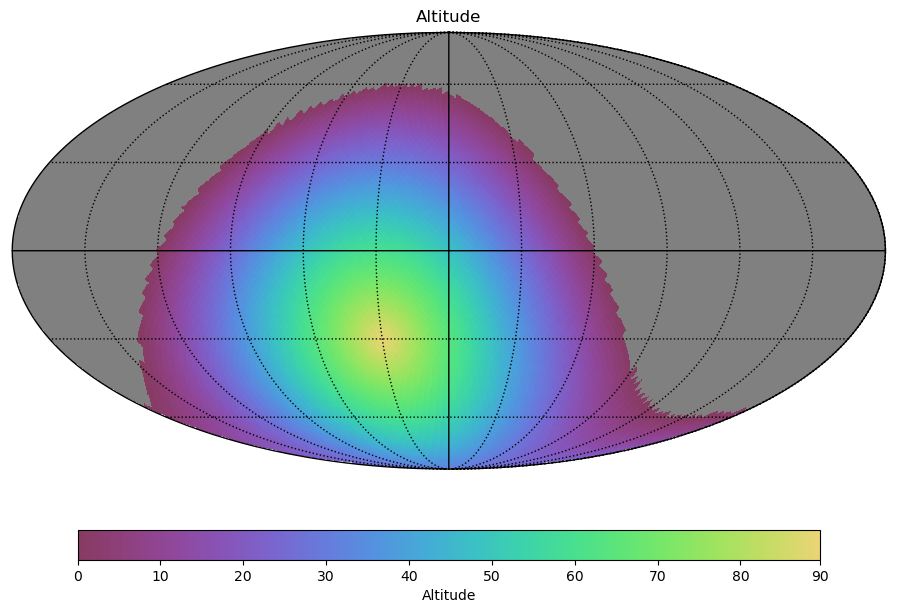

In [7]:
val = ma.MaskedArray(data=np.degrees(alt), mask=altmask)
plotDict = {'figsize':(10, 6), 'title': 'Altitude', 'xlabel': 'Altitude'}
plots.HealpixSkyMap()(val, s, plotDict)

In [8]:
def get_trajectory_instance_case(distance, v_max, acc_max, jerk_max):
    """Determine which motion profile to use.

    Modified from https://github.com/mdhom/py_constant_jerk/blob/main/constantJerk.py

    Parameters
    ----------
    distance : `float`
        The distance to travel. Could be units of length or angle as long as other
        parameters match.
    v_max : `float`
        The maximum velocity. Units of length or angle per unit of time.
    acc_max : `float`
        The maximum acceleration. Units of length or angle per unit of time squared.
    jerk_max : `float`
        The maximum jerk. Units of length or angle per unit of time cubed.

    """
    # Which case applies depends on v_max and distance moved.
    # Case 1 & 3 & 4 - v_max < v_a (v_max reached)
    #   [2 & 5 & 6 v_max >= v_a]
    # Case 1 & 5 & 6 - s >= s_a (max acceleration reached?)
    #   [2 & 3 & 4, s < s_a]
    # Case 3 & 5 - s >= s_v (max velocity reached)
    #   [ 4 & 6 - s < s_v]  .. 1 & 2 distance not relevant.
    # Case 1: a_max reached, v_max reached and constant for a time
    #          (s = 100,   j = 2000, a = 500,  vMax = 120)
    # Case 2: a_max not reached, v_max not reached
    #          (s = 15000, j = 2000, a = 5500, vMax = 20500)
    # Case 3: a_max not reached, v_max reached and constant for a time
    #          (s = 15000, j = 2000, a = 5500, vMax = 2500)
    # Case 4: a_max reached, v_max not reached
    #          (s = 57,    j = 2000, a = 500,  vMax = 120)
    # Case 5: a_max reached *and constant for a time*,
    # v_max reached and constant for a time
    #          (s = 15000, j = 2000, a = 500,  vMax = 2500)
    # Case 6: a_max reached and constant for a time, v_max not reached
    #          (s = 15000, j = 2000, a = 500,  vMax = 20500)

    result = np.array(distance * 0)

    v_a = acc_max * acc_max / jerk_max
    s_a = 2 * acc_max * acc_max * acc_max / (jerk_max * jerk_max)
    s_v = 0.0
    if v_max * jerk_max < acc_max * acc_max:
        s_v = v_max * 2 * np.sqrt(v_max / jerk_max)
    else:
        s_v = v_max * (v_max / acc_max + acc_max / jerk_max)

    result[np.where((v_max < v_a) & (distance >= s_a))] = 1
    result[np.where((v_max >= v_a) & (distance < s_a))] = 2
    result[np.where((v_max < v_a) & (distance < s_a) & (distance >= s_v))] = 3
    result[np.where((v_max < v_a) & (distance < s_a) & (distance < s_v))] = 4
    result[np.where((v_max >= v_a) & (distance >= s_a) & (distance >= s_v))] = 5
    result[np.where((v_max >= v_a) & (distance >= s_a) & (distance < s_v))] = 6

    return result

def calc_distances(alt_rad, az_rad, starting_alt_rad, starting_az_rad, tel):
    delta_alt = np.abs(alt_rad - starting_alt_rad)
    delta_az_short = smallest_signed_angle(starting_az_rad, az_rad)
    delta_az_long = delta_az_short - two_pi
    daslz = np.where(delta_az_short < 0)[0]
    delta_az_long[daslz] = two_pi + delta_az_short[daslz]
    # So, for every position, we can get there by slewing long or short way
    cummulative_az_short = delta_az_short + tel.cumulative_azimuth_rad
    oob = np.where(
        (cummulative_az_short < tel.telaz_minpos_rad) | (cummulative_az_short > tel.telaz_maxpos_rad)
    )[0]
    # Set out of bounds azimuths to infinite distance
    delta_az_short[oob] = np.inf
    cummulative_az_long = delta_az_long + tel.cumulative_azimuth_rad
    oob = np.where(
        (cummulative_az_long < tel.telaz_minpos_rad) | (cummulative_az_long > tel.telaz_maxpos_rad)
    )[0]
    delta_az_long[oob] = np.inf

    # Find minimum azimuth slew out of long/short direction (use absolute, because these can be negative)
    # Note that with an impaired telescope with az range<180, infinite slewtimes can propagate
    delta_aztel = np.where(
        np.abs(delta_az_short) < np.abs(delta_az_long),
        delta_az_short,
        delta_az_long,
    )
    return delta_alt, delta_aztel

ra/dec 29.880630162719783 10.0 alt/az 49.75559999999999 1.2074182697257333e-06
4.072256254338347 155.7346108351059


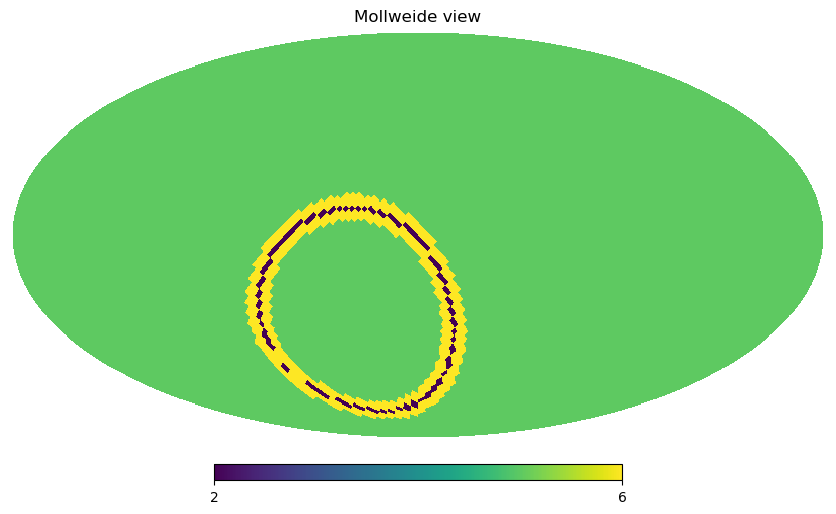

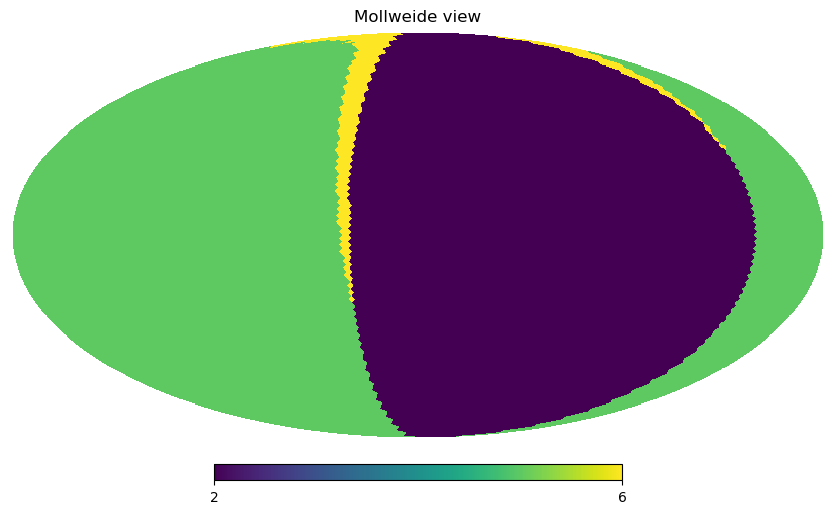

In [10]:
# Telescope position
telRA = np.radians(lmst_deg)
telDec = np.radians(10)
telAlt, telAz = stackers.ra_dec2_alt_az(np.array([telRA]), np.array([telDec]),
                                     lsstSite.latitude_rad, lsstSite.longitude_rad, tnow)
telAlt = telAlt[0]
telAz = telAz[0]
print('ra/dec', np.degrees(telRA), np.degrees(telDec), 'alt/az', np.degrees(telAlt), np.degrees(telAz))

tel = KinemModel(mjd0=tnow, start_filter='r')
tel.setup_camera(jerk=None)
tel.setup_dome(altitude_jerk=None, azimuth_jerk=None)
tel.setup_telescope(altitude_jerk=3.5*3, azimuth_jerk=7.0*3)
slewtime = tel.slew_times(ra_rad=None, dec_rad=None, mjd=tnow, 
                          alt_rad=alt, az_rad=az,
                          starting_alt_rad=telAlt,starting_az_rad=telAz, starting_rot_tel_pos_rad=None, 
                          filtername='r')
print(np.nanmin(slewtime), np.nanmax(slewtime))

delta_alt, delta_aztel = calc_distances(alt, az, telAlt, telAz, tel)
tic_alt = get_trajectory_instance_case(delta_alt, tel.telalt_maxspeed_rad, tel.telalt_accel_rad, tel.telalt_jerk_rad)
tic_az = get_trajectory_instance_case(delta_aztel, tel.telaz_maxspeed_rad, tel.telaz_accel_rad, tel.telaz_jerk_rad)
hp.mollview(tic_alt)
hp.mollview(tic_az)

In [11]:
# Telescope position
telRA = np.radians(lmst_deg)
telDec = np.radians(10)
telAlt, telAz = stackers.ra_dec2_alt_az(np.array([telRA]), np.array([telDec]),
                                     lsstSite.latitude_rad, lsstSite.longitude_rad, tnow)
telAlt = telAlt[0]
telAz = telAz[0]
print('ra/dec', np.degrees(telRA), np.degrees(telDec), 'alt/az', np.degrees(telAlt), np.degrees(telAz))

tel = KinemModel(mjd0=tnow, start_filter='r')
tel.setup_camera(jerk=None)
tel.setup_dome(altitude_jerk=None, azimuth_jerk=None)
tel.setup_telescope(altitude_jerk=3.5*3, azimuth_jerk=7.0*3)
slewtime = tel.slew_times(ra_rad=None, dec_rad=None, mjd=tnow, 
                          alt_rad=alt, az_rad=az,
                          starting_alt_rad=telAlt,starting_az_rad=telAz, starting_rot_tel_pos_rad=None, 
                          filtername='r')
print(np.nanmin(slewtime), np.nanmax(slewtime))

tel_old = KinemModel_old(mjd0=tnow, start_filter='r')
slewtime_old = tel_old.slew_times(ra_rad=None, dec_rad=None, mjd=tnow, 
                          alt_rad=alt, az_rad=az, 
                          starting_alt_rad=telAlt,starting_az_rad=telAz, starting_rot_tel_pos_rad=None, 
                          filtername='r')
print(np.nanmin(slewtime_old), np.nanmax(slewtime_old))

ra/dec 29.880630162719783 10.0 alt/az 49.75559999999999 1.2074182697257333e-06
4.072256254338347 155.7346108351059
3.6799289234976 155.7346108351059


2

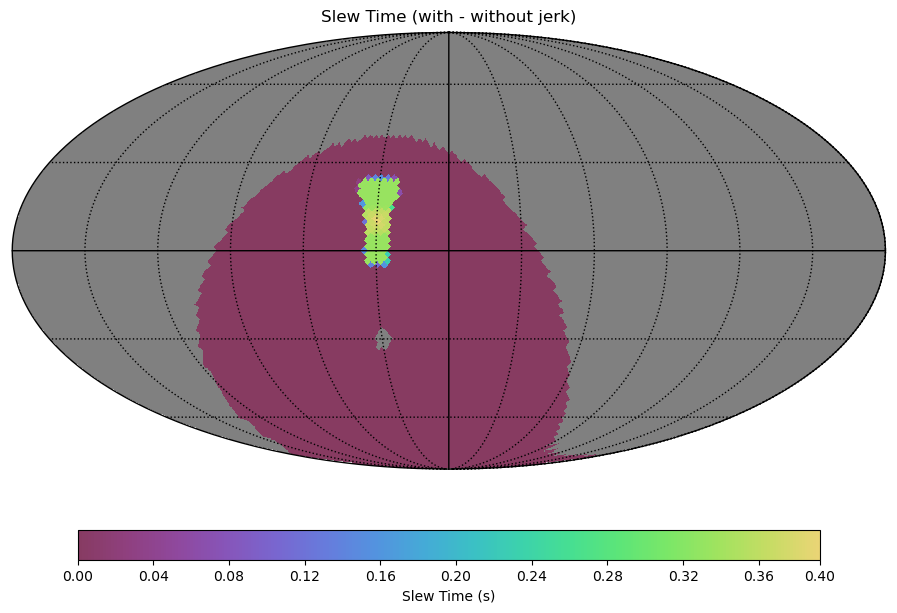

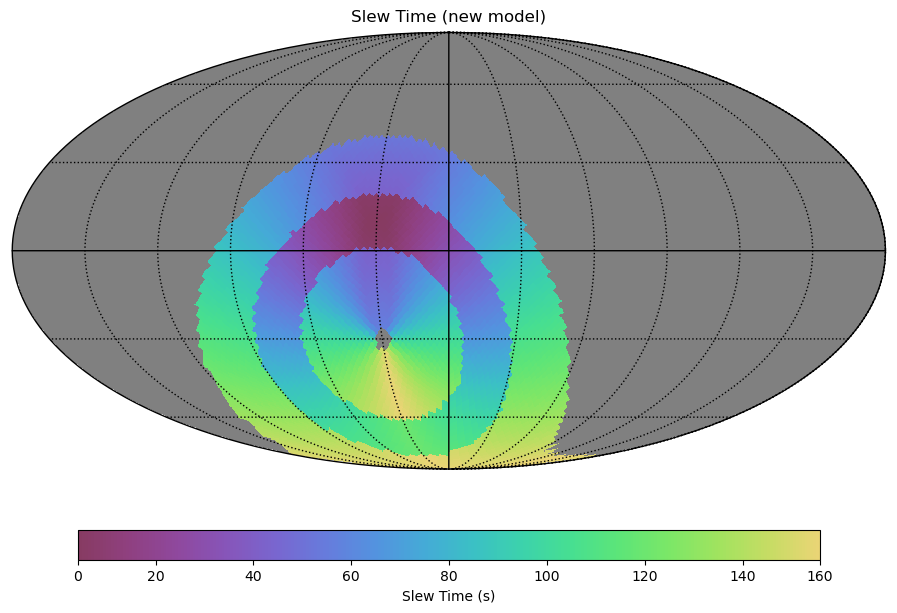

In [13]:
val = ma.MaskedArray(data=slewtime- slewtime_old)
plotDict = {'figsize':(10, 6), 'title': 'Slew Time (with - without jerk)', 'xlabel': 'Slew Time (s)',
           'color_min': np.nanmin(val), 'color_max': np.nanmax(val)}
plots.HealpixSkyMap()(val, s, plotDict)

val = ma.MaskedArray(data=slewtime)
plotDict = {'figsize':(10, 6), 'title': 'Slew Time (new model)', 'xlabel': 'Slew Time (s)',
           'color_min': np.nanmin(val), 'color_max': np.nanmax(val)}
plots.HealpixSkyMap()(val, s, plotDict)

In [14]:
# First get observatory model set up correctly. 
# tnow is in MJD (TAI) and we need to convert to unix timestamp.
from astropy.time import Time
t = Time(tnow, format='mjd', scale='tai')

from lsst.ts.observatory.model import Target
from lsst.ts.observatory.model import ObservatoryModel
from lsst.ts.observatory.model import ObservatoryState
from lsst.ts.observatory.model import ObservatoryPosition

observatoryModel = ObservatoryModel()
observatoryModel.configure_from_module()
observatoryModel.update_state(t.unix)
observatoryModel.params.follow_sky = False
print(observatoryModel)

t=1640995163.0 ra=29.726 dec=-26.744 ang=180.000 filter=r track=False alt=86.500 az=0.000 pa=180.000 rot=0.000 telaz=0.000 telrot=0.000 mounted=['g', 'r', 'i', 'z', 'y'] unmounted=['u']


In [23]:
# Set new observatory position/state.
startTarget = Target(band_filter='g', ra_rad=telRA, dec_rad=telDec, num_exp=1, exp_times=[15.0, 15.0])
print(startTarget)
observatoryModel.slew(startTarget)
observatoryModel.update_state(t.unix)
print(observatoryModel)
print("")
print(observatoryModel.current_state)

targetid=0 field=0 filter=g exp_times=[15.0, 15.0] ra=29.881 dec=10.000 ang=0.000 alt=0.000 az=0.000 rot=0.000 telalt=0.000 telaz=0.000 telrot=0.000 time=0.0 airmass=0.000 brightness=0.000 cloud=0.00 seeing=0.00 visits=0 progress=0.00% seqid=0 ssname= groupid=0 groupix=0 firstdd=False ddvisits=0 need=0.000 bonus=0.000 value=0.000 propboost=1.000 propid=[] need=[] bonus=[] value=[] propboost=[] slewtime=0.000 cost=0.000 rank=0.000
t=1640995311.0 ra=29.881 dec=10.000 ang=180.207 filter=g track=True alt=49.753 az=359.293 pa=179.380 rot=359.173 telaz=-0.707 telrot=-0.827 mounted=['g', 'r', 'i', 'z', 'y'] unmounted=['u']

t=1640995311.0 ra=29.881 dec=10.000 ang=180.207 filter=g track=True alt=49.753 az=359.293 pa=179.380 rot=359.173 telaz=-0.707 telrot=-0.827 mounted=['g', 'r', 'i', 'z', 'y'] unmounted=['u']


In [24]:
slewT = np.zeros(len(ra), float)
for i in range(len(slewT)):
    target = Target(band_filter='g', ra_rad=ra[i], dec_rad=dec[i], num_exp=2, exp_times=[15.0, 15.0])
    slewT[i] = observatoryModel.get_slew_delay(target)
    print(observatoryModel.current_state)
    break
slewT.min(), slewT.max()

t=1640995311.0 ra=29.881 dec=10.000 ang=180.207 filter=g track=True alt=49.753 az=359.293 pa=179.380 rot=359.173 telaz=-0.707 telrot=-0.827 mounted=['g', 'r', 'i', 'z', 'y'] unmounted=['u']


(-1.0, 0.0)

1

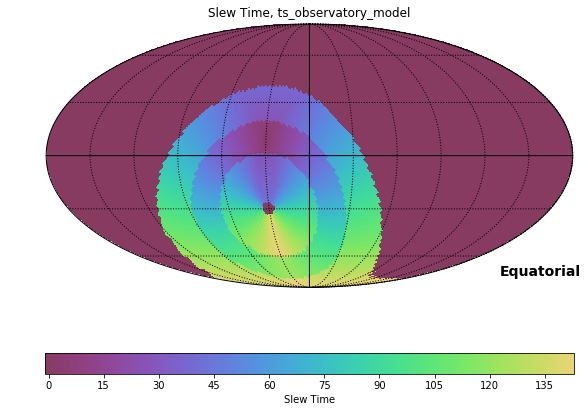

In [17]:
val = ma.MaskedArray(data=slewT, mask=False)
plotDict = {'figsize':(10, 6), 'title': 'Slew Time, ts_observatory_model', 'xlabel': 'Slew Time'}
plots.HealpixSkyMap()(val, s, plotDict)

Min and max differences between Fast - ts_observatory_model -20.1850537016 143.817511166


1

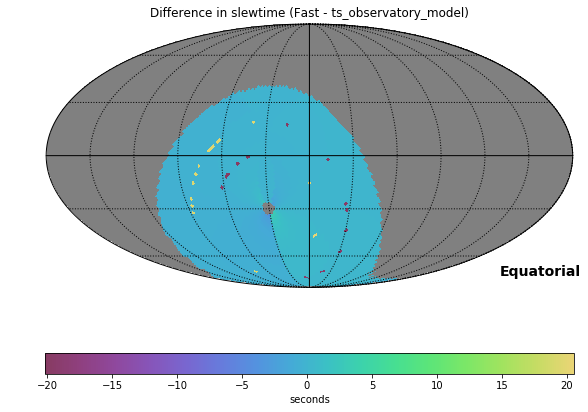

In [20]:
newmask = np.where(slewT<=0, True, False)
diff = slewtime - slewT
print('Min and max differences between Fast - ts_observatory_model', diff.min(), diff.max())
val = ma.MaskedArray(data=diff, mask=newmask)
plotDict = {'figsize':(10, 6), 'title': 'Difference in slewtime (Fast - ts_observatory_model)', 
            'xlabel': 'seconds',
            'colorMin':-.5, 'colorMax':1}
plots.HealpixSkyMap()(val, s, plotDict)

In [13]:
# Now do it using SOCS
import copy
from lsst.sims.ocs.observatory import MainObservatory
from lsst.sims.ocs.configuration import ObservingSite, Observatory
mo = MainObservatory(ObservingSite())
mo.configure(Observatory())
model = mo.model

def opsimSlewTime(model, alt1=None, alt2=None, az1=None, az2=None, rot1=None, rot2=None):
    # park the observatory, then go from alt1,az1 to alt2,az2
    if alt1 is None:
        alt1 = model.current_state.alt
    if alt2 is None:
        alt2 = model.current_state.alt
    if az1 is None:
        az1 = model.current_state.az
    if az2 is None:
        az2 = model.current_state.az
    if rot1 is None:
        rot1 = model.current_state.rot
    if rot2 is None:
        rot2 = model.current_state.rot

    model.park()
    model.slew_altaz(0., np.radians(alt1), np.radians(az1), np.radians(rot1), model.current_state.filter)
    initial_slew_state = copy.deepcopy(model.current_state)

    model.slew_altaz(model.current_state.time, np.radians(alt2), np.radians(az2), np.radians(rot2),
                     model.current_state.filter)

    final_slew_state = copy.deepcopy(model.current_state)
    slew_time = final_slew_state.time - initial_slew_state.time

    return slew_time

In [14]:
slewT2 = np.zeros(len(ra), float)
for i in range(len(slewT2)):
    slewT2[i] = opsimSlewTime(model, alt1=np.degrees(telAlt), az1=np.degrees(telAz),
                              alt2=np.degrees(alt[i]), az2=np.degrees(az[i]), rot1=None, rot2=None)
slewT2.min(), slewT2.max()

(3.6799288833281025, 142.81751116574742)

1

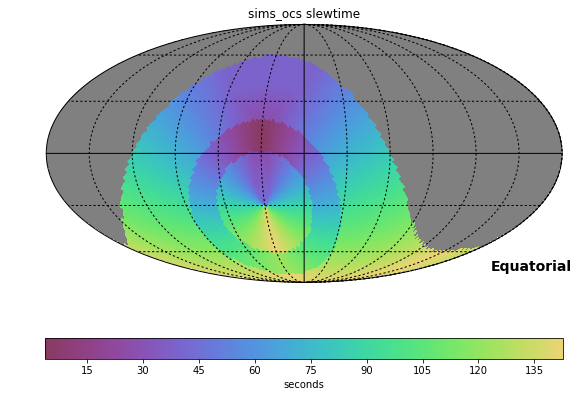

In [15]:
val = ma.MaskedArray(data=slewT2, mask=azmask)
plotDict = {'figsize':(10, 6), 'title': 'sims_ocs slewtime', 'xlabel': 'seconds'}
plots.HealpixSkyMap()(val, s, plotDict)

('Min and max differences between SOCS-ts_observatory_model', -20.185053701635155, 143.81751116574742)


1

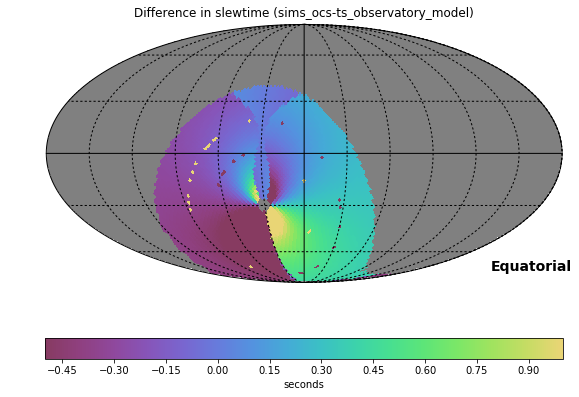

In [16]:
diff = slewT2 - slewT
print('Min and max differences between SOCS-ts_observatory_model', diff.min(), diff.max())
val = ma.MaskedArray(data=diff, mask=newmask)
plotDict = {'figsize':(10, 6), 'title': 'Difference in slewtime (sims_ocs-ts_observatory_model)',
            'xlabel': 'seconds', 'colorMin':-.5, 'colorMax':1}
plots.HealpixSkyMap()(val, s, plotDict)

('Min and max differences between SOCS - Fast', -61.388526965070511, 2.326032699784264e-10)


1

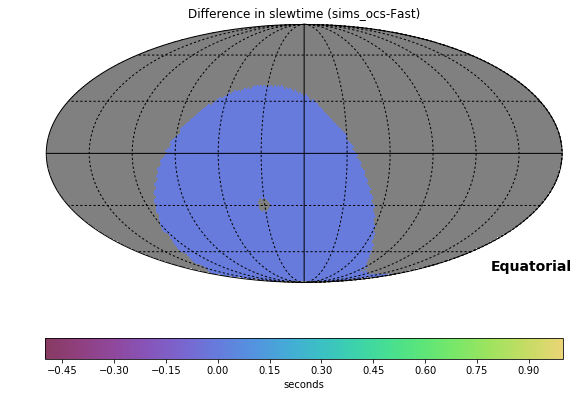

In [17]:
diff = slewT2 - slewtime
print('Min and max differences between SOCS - Fast', diff.min(), diff.max())
val = ma.MaskedArray(data=diff, mask=newmask)
plotDict = {'figsize':(10, 6), 'title': 'Difference in slewtime (sims_ocs-Fast)',
            'xlabel': 'seconds', 'colorMin':-.5, 'colorMax':1}
plots.HealpixSkyMap()(val, s, plotDict)

Maybe the difference is due to the "History" of the telescope? But in both, sims_ocs and ts_observatory, we're moving from zenith/park to telAlt/Az and then on to alt/az of the pointing. So the cable wrap effects should be the same. 